# Experiment 3: Zero-Shot Pollen Reconstruction with Hunyuan-3D-2

In [1]:
import pandas as pd

In [2]:
results = pd.read_csv("../eval/TestEvaluation/mesh_eval_results.csv")

# print all models names unique
print("Models names unique:")
print(results["model"].unique())

Models names unique:
['Hunyuan3D' 'Hunyuan3D-four-views' 'Hunyuan3D-two-views']


In [3]:
relevant_models = [
    "Hunyuan3D-two-views",
    "Hunyuan3D-four-views",
    "Hunyuan3D",
    # extend with Pixel2Mesh++ and PixelNeRF names as in the CSV file
]

filtered = results[results["model"].isin(relevant_models)]

aggregated = filtered.groupby("model", as_index=False).agg(
    mean_chamfer=("chamfer", "mean"),
    std_chamfer=("chamfer", "std"),
    mean_fscore_1=("fscore_1", "mean"),
    std_fscore_1=("fscore_1", "std"),
    mean_fscore_2_5=("fscore_2_5", "mean"),
    std_fscore_2_5=("fscore_2_5", "std"),
    mean_fscore_5=("fscore_5", "mean"),
    std_fscore_5=("fscore_5", "std"),
    mean_iou=("voxel_iou", "mean"),
    std_iou=("voxel_iou", "std"),
)

aggregated

,model,mean_chamfer,std_chamfer,mean_fscore_1,std_fscore_1,mean_fscore_2_5,std_fscore_2_5,mean_fscore_5,std_fscore_5,mean_iou,std_iou
0,Hunyuan3D,0.047692,0.014846,0.226753,0.100908,0.696755,0.143823,0.893022,0.086628,0.760170,0.103843
1,Hunyuan3D-four-views,0.044270,0.012927,0.257179,0.098112,0.735474,0.127215,0.904999,0.076317,0.778854,0.098970
2,Hunyuan3D-two-views,0.043222,0.012634,0.259323,0.086860,0.751798,0.124725,0.911488,0.077970,0.790453,0.095833


In [4]:
import vtk
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk
import numpy as np
import matplotlib.pyplot as plt
import sys
import trimesh
import os
from pathlib import Path

# Try to import fast_simplification, use alternative if not available
try:
    import fast_simplification

    HAS_FAST_SIMPLIFICATION = True
except ImportError:
    HAS_FAST_SIMPLIFICATION = False
    print(
        "fast_simplification not available, using trimesh.simplify_quadric_decimation instead"
    )

sys.path.append("../")

from TestEvaluationPipeline.mesh_utils import MeshUtils

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
def set_axes_equal_and_zoom(ax, mesh, zoom=1.0):
    """Set equal aspect ratio and zoom for 3D plot."""
    xyz = mesh.vertices
    mins = xyz.min(axis=0)
    maxs = xyz.max(axis=0)
    center = (mins + maxs) / 2
    half = (maxs - mins).max() * zoom / 2

    ax.set_xlim(center[0] - half, center[0] + half)
    ax.set_ylim(center[1] - half, center[1] + half)
    ax.set_zlim(center[2] - half, center[2] + half)
    ax.set_box_aspect((1, 1, 1))


def find_mesh_file(model_dir, base_name, exts=(".stl", ".obj")):
    """
    Look for a file in model_dir whose name contains base_name and ends with one of the given extensions.
    """
    base = Path(model_dir)
    # try scanning for any file matching pattern *base_name*ext
    for ext in exts:
        pattern = f"*{base_name}*{ext}"
        matches = list(base.glob(pattern))
        if matches:
            return str(matches[0])
    # fallback to any file containing base_name
    globbed = list(base.glob(f"*{base_name}*.*"))
    if globbed:
        return str(globbed[0])
    raise FileNotFoundError(f"No mesh file containing '{base_name}' in '{model_dir}'")

In [6]:
def plot_mesh_grid(
    basenames,
    model_dirs,
    model_names=None,
    exts=(".stl", ".obj"),
    zoom=0.8,
    figsize=(12, 6),
    color="#1b669b",  # Blue color like in exp_1
):
    """
    Plot a grid of meshes comparing different models.

    basenames    : list of mesh name substrings WITHOUT extension
    model_dirs   : list of directory paths (first one = GT)
    model_names  : optional list of column titles
    exts         : tuple of extensions to try (default .stl and .obj)
    zoom         : <1 zooms in (meshes look larger), >1 zooms out
    figsize      : figure size for plt.figure
    color        : color for the mesh surfaces
    """
    n_rows = len(basenames)
    n_cols = len(model_dirs)

    if model_names is None:
        model_names = [os.path.basename(os.path.normpath(d)) for d in model_dirs]

    fig, axes = plt.subplots(
        n_rows, n_cols, subplot_kw={"projection": "3d"}, figsize=figsize, squeeze=False
    )

    for i, name in enumerate(basenames):
        # load GT for this row
        gt_path = find_mesh_file(model_dirs[0], name, exts)
        gt = trimesh.load(gt_path)

        for j, model_dir in enumerate(model_dirs):
            ax = axes[i, j]
            # styling
            ax.grid(False)
            ax.xaxis.pane.fill = False
            ax.yaxis.pane.fill = False
            ax.zaxis.pane.fill = False
            for spine in (ax.xaxis, ax.yaxis, ax.zaxis):
                spine.pane.set_edgecolor("none")
            ax.set_axis_off()

            # load & align or just use GT
            if j == 0:
                mesh = gt
            else:
                pred_path = find_mesh_file(model_dir, name, exts)
                pred = trimesh.load(pred_path)

                # No mesh simplification - use original mesh
                aligned, _ = MeshUtils.align_icp(pred, gt)
                mesh = trimesh.Trimesh(vertices=aligned.vertices, faces=pred.faces)

            # plot
            ax.plot_trisurf(
                mesh.vertices[:, 0],
                mesh.vertices[:, 1],
                mesh.vertices[:, 2],
                triangles=mesh.faces,
                color=color,
            )

            # title on first row
            if i == 0:
                ax.set_title(model_names[j])

            # equal aspect & zoom
            set_axes_equal_and_zoom(ax, mesh, zoom=zoom)

    plt.tight_layout()
    plt.show()

In [7]:
# Define the mesh filenames to visualize (same as in exp_1)
filenames = [
    "17781_Common_thyme_Thymus_vulgaris_pollen_grain",
    "17803_Ox-eye_daisy_Leucanthemum_vulgare_pollen_grain",
    "21555_Hard_rush_Juncus_inflexus_pollen_grain_shrunken",
    "21188_Meadow_goats_beard_Tragopogon_pratensis_pollen_grain",
    "17878_Alder_Alnus_sp_pollen_grain_pentaporate",
]

## Hunyuan3D Model Comparison

Visual comparison of Ground Truth meshes with Hunyuan3D variants (two-views, four-views, and standard) in blue color.

### With just 5 steps inference

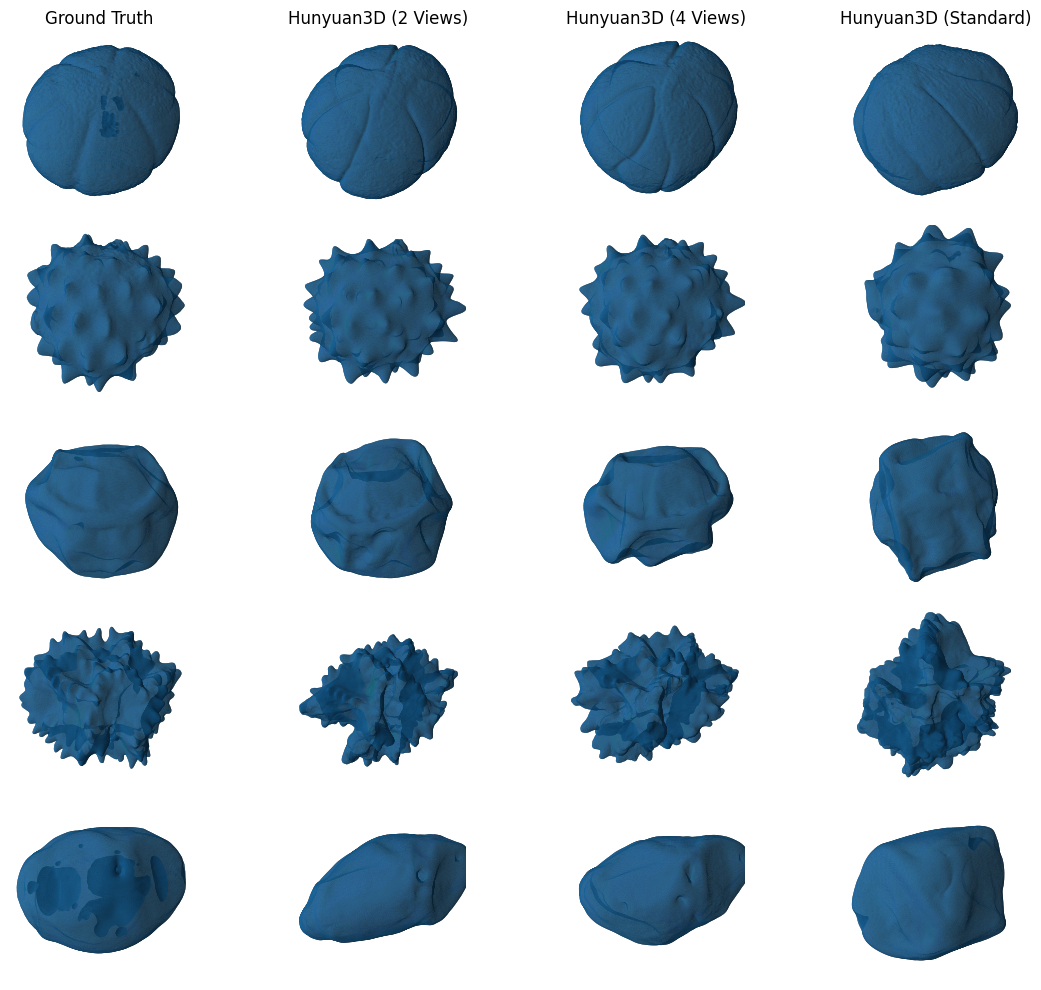

In [8]:
# Define model directories for Hunyuan3D comparison
model_dirs = [
    r"C:\Users\super\Documents\Github\sequoia\data\processed\interim",  # Ground Truth
    r"C:\Users\super\Documents\Github\sequoia\TestEvaluationPipeline\data\Hunyuan3D-two-views",
    r"C:\Users\super\Documents\Github\sequoia\TestEvaluationPipeline\data\Hunyuan3D-four-views",
    r"C:\Users\super\Documents\Github\sequoia\TestEvaluationPipeline\data\Hunyuan3D",
]

model_names = [
    "Ground Truth",
    "Hunyuan3D (2 Views)",
    "Hunyuan3D (4 Views)",
    "Hunyuan3D (Standard)",
]

# Create the visualization with blue color like in exp_1
plot_mesh_grid(
    filenames,
    model_dirs,
    model_names,
    zoom=0.65,
    figsize=(12, 10),
    color="#1b669b",  # Blue color
)

### With 50 steps

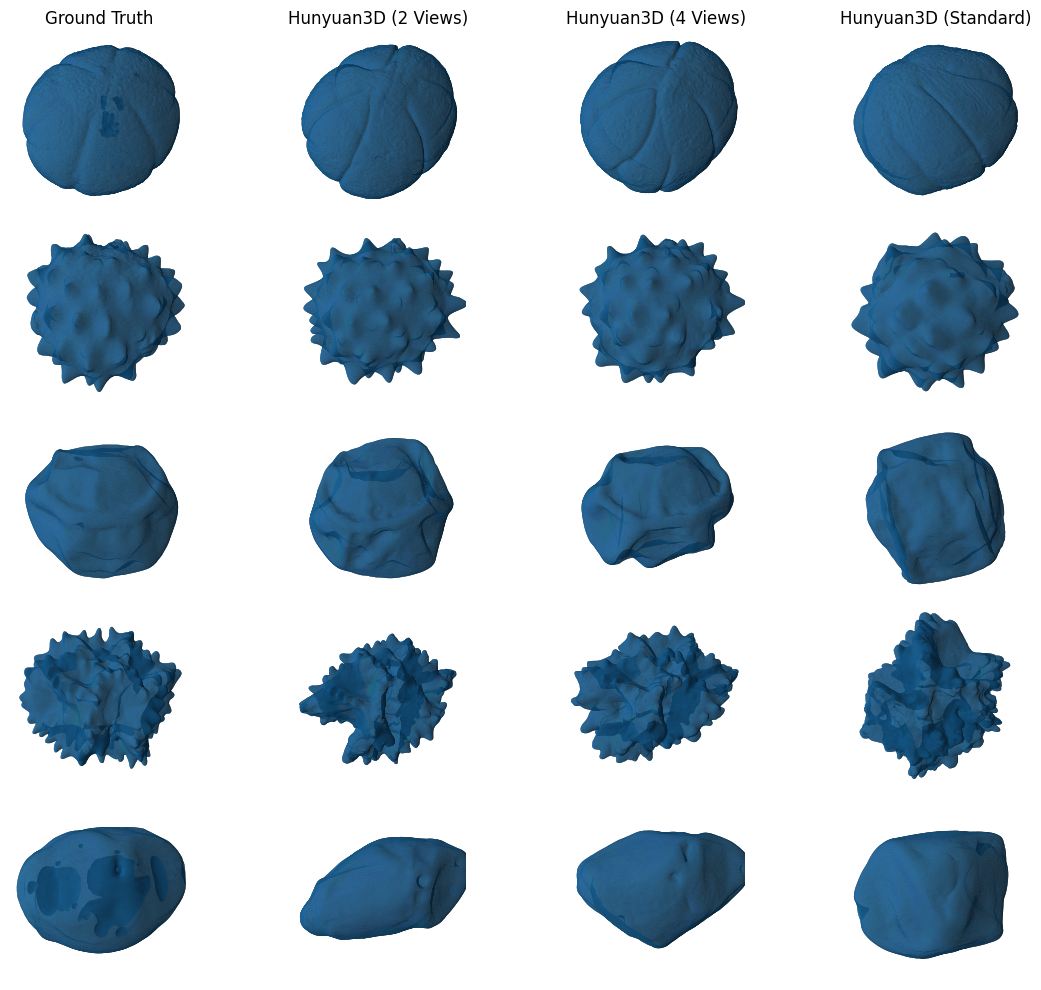

In [9]:
# Define model directories for Hunyuan3D comparison
base_path = r"C:\Users\super\Documents\Github\sequoia\data\results_50steps"
model_dirs = [
    r"C:\Users\super\Documents\Github\sequoia\data\processed\interim",  # Ground Truth
    rf"{base_path}\Hunyuan3D-two-views",
    rf"{base_path}\Hunyuan3D-four-views",
    rf"{base_path}\Hunyuan3D",
]

model_names = [
    "Ground Truth",
    "Hunyuan3D (2 Views)",
    "Hunyuan3D (4 Views)",
    "Hunyuan3D (Standard)",
]

# Create the visualization with blue color like in exp_1
plot_mesh_grid(
    filenames,
    model_dirs,
    model_names,
    zoom=0.65,
    figsize=(12, 10),
    color="#1b669b",  # Blue color
)

## Individual Model Comparisons

Detailed comparison of each Hunyuan3D variant against Ground Truth.

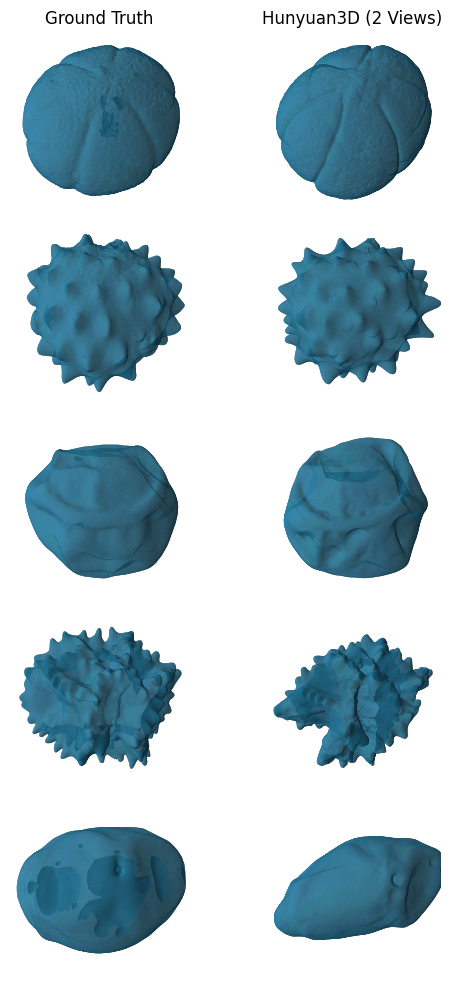

In [10]:
# Hunyuan3D Two Views vs Ground Truth
model_dirs_2views = [
    r"C:\Users\super\Documents\Github\sequoia\data\processed\interim",  # Ground Truth
    r"C:\Users\super\Documents\Github\sequoia\TestEvaluationPipeline\data\Hunyuan3D-two-views",
]

model_names_2views = ["Ground Truth", "Hunyuan3D (2 Views)"]

plot_mesh_grid(
    filenames,
    model_dirs_2views,
    model_names_2views,
    zoom=0.65,
    figsize=(6, 10),
    color="#2E86AB",
)

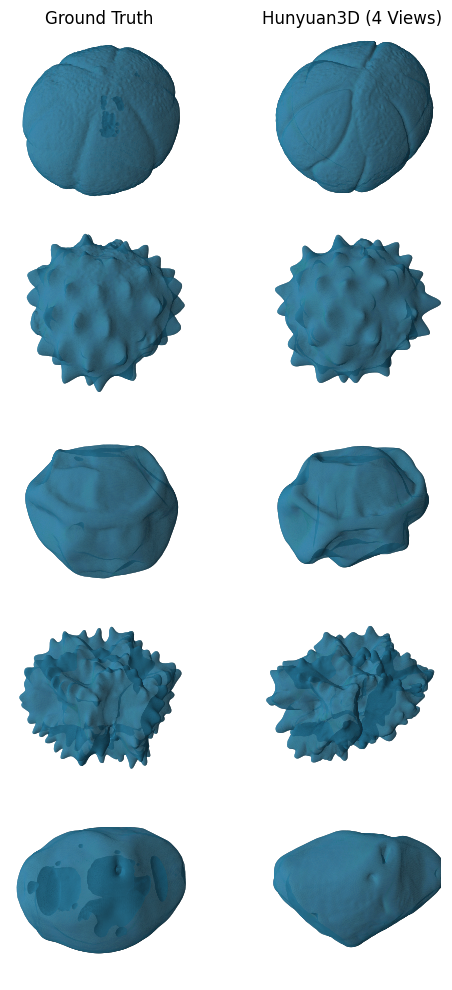

In [11]:
# Hunyuan3D Four Views vs Ground Truth
model_dirs_4views = [
    r"C:\Users\super\Documents\Github\sequoia\data\processed\interim",  # Ground Truth
    r"C:\Users\super\Documents\Github\sequoia\TestEvaluationPipeline\data\Hunyuan3D-four-views",
]

model_names_4views = ["Ground Truth", "Hunyuan3D (4 Views)"]

plot_mesh_grid(
    filenames,
    model_dirs_4views,
    model_names_4views,
    zoom=0.65,
    figsize=(6, 10),
    color="#2E86AB",
)

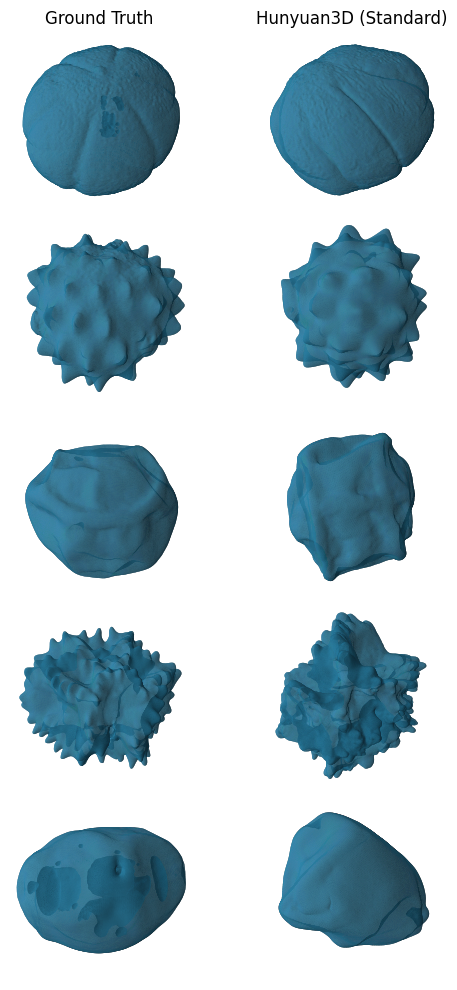

In [12]:
# Hunyuan3D Standard vs Ground Truth
model_dirs_standard = [
    r"C:\Users\super\Documents\Github\sequoia\data\processed\interim",  # Ground Truth
    r"C:\Users\super\Documents\Github\sequoia\TestEvaluationPipeline\data\Hunyuan3D",
]

model_names_standard = ["Ground Truth", "Hunyuan3D (Standard)"]

plot_mesh_grid(
    filenames,
    model_dirs_standard,
    model_names_standard,
    zoom=0.65,
    figsize=(6, 10),
    color="#2E86AB",
)

Comparing hyperparameters for: 17803_Ox-eye_daisy_Leucanthemum_vulgare_pollen_grain


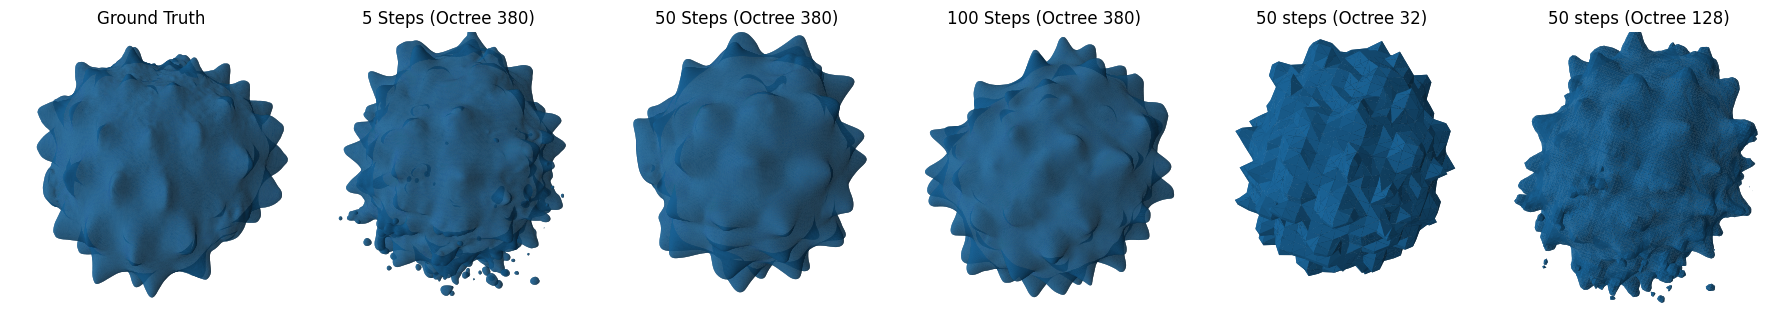

In [13]:
# Hyperparameter Comparison for Ox-eye Daisy
# Compare different inference steps and octree resolutions

# Single mesh for comparison
comparison_mesh = "17803_Ox-eye_daisy_Leucanthemum_vulgare_pollen_grain"

# Define model directories for hyperparameter comparison
hyperparameter_dirs = [
    r"C:\Users\super\Documents\Github\sequoia\data\processed\interim",  # Ground Truth
    r"C:\Users\super\Documents\Github\sequoia\data\results\Hunyuan3D",  # 5 steps (default)
    r"C:\Users\super\Documents\Github\sequoia\data\results_50steps\Hunyuan3D",  # 50 steps
    r"C:\Users\super\Documents\Github\sequoia\data\results_100steps\Hunyuan3D",  # 100 steps
    r"C:\Users\super\Documents\Github\sequoia\data\results_octree32\Hunyuan3D",  # Octree 32
    r"C:\Users\super\Documents\Github\sequoia\data\results_octree128\Hunyuan3D",  # Octree 128
]

hyperparameter_names = [
    "Ground Truth",
    "5 Steps (Octree 380)",
    "50 Steps (Octree 380)",
    "100 Steps (Octree 380)",
    "50 steps (Octree 32)",
    "50 steps (Octree 128)",
]

print(f"Comparing hyperparameters for: {comparison_mesh}")

# Create the visualization focusing on hyperparameter variations
plot_mesh_grid(
    [comparison_mesh],  # Single mesh
    hyperparameter_dirs,
    hyperparameter_names,
    zoom=0.65,
    figsize=(18, 4),  # Wide figure to accommodate all variants
    color="#1b669b",  # Blue color consistent with other plots
)